# implied counts

In [1]:
%load_ext autoreload
%autoreload 2
%autosave 0

Autosave disabled


In [2]:
from pathlib import Path
from numpy.random import randint
from pandas import DataFrame, Series, date_range, read_csv

**Confirmed** cases:

- P(confirmed | not exposed) = 0. No false confirmations.
- P(confirmed | exposed) = `CPROB`. Many exposures are never confirmed.
- Confirmations occur `CTIME` days after exposure.

**Deceased** cases:

- P(deceased | exposed) = 0. All deaths are confirmed cases.
- Deaths occur `DTIME` days after exposure.

In [3]:
CPROB = 0.05
CTIME = 7
DTIME = CTIME + 10
FOLDER = Path('../data/rivm').resolve()
FIGSIZE = (9, 5)

## realized counts

Load examples from [CoronaWatchNL] via jonathandebruinos@gmail.com.

[CoronaWatchNL]: https://github.com/J535D165/CoronaWatchNL

In [4]:
def read(name):
    path = (FOLDER / name).with_suffix('.csv')
    data = read_csv(path, parse_dates=['Datum'], index_col='Datum')
    return data.pop('Aantal').rename_axis('date')

real = (
    DataFrame()
    .assign(confirmed = read('confirmed'))
    .assign(deceased = read('deceased'))
    .assign(hospitalized = read('hospitalized'))
    .resample('D').sum().astype(int)
)
real.tail()

,confirmed,deceased,hospitalized
date,,,
2020-03-25,6412,356,1836
2020-03-26,7431,434,2151
2020-03-27,8603,546,2500
2020-03-28,9762,639,2954
2020-03-29,10866,771,3483


## implied exposures
Adjust for confirmation lag and unconfirmed exposures.

In [5]:
exposed = (
    real['confirmed'].rename('exposed')
    .shift(-CTIME, freq=real.index.freq)
    .div(CPROB)
)
implied = real.join(exposed, how='outer')
implied.tail()

,confirmed,deceased,hospitalized,exposed
date,,,,
2020-03-25,6412.0,356.0,1836.0,NaN
2020-03-26,7431.0,434.0,2151.0,NaN
2020-03-27,8603.0,546.0,2500.0,NaN
2020-03-28,9762.0,639.0,2954.0,NaN
2020-03-29,10866.0,771.0,3483.0,NaN


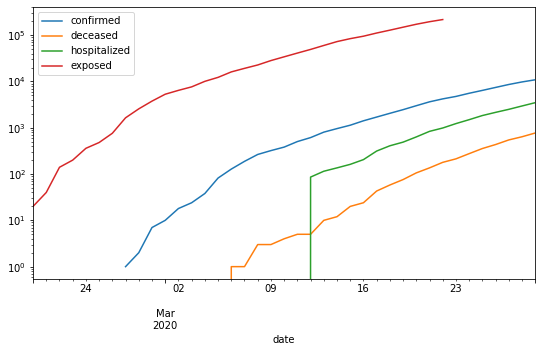

In [6]:
axes = implied.plot(figsize=FIGSIZE, logy=True)

## implied fatality rates
Estimate [case fatality rate] and infection fatality rate.

[case fatality rate]: https://en.wikipedia.org/wiki/Case_fatality_rate

In [7]:
deaths = real['deceased'][-1]

cfr = deaths / real['confirmed'][-(1 + DTIME - CTIME)]
print(f"{cfr.round(3)} deaths per confirmed case")

ifr = deaths / implied['exposed'][-(1 + DTIME)]
print(f"{ifr.round(3)} deaths per implied exposure")

0.313 deaths per confirmed case
0.016 deaths per implied exposure
